In [ ]:
# hide
# skip
!git clone https://github.com/benihime91/gale # install gale on colab
!pip install -e "gale[dev]"

In [ ]:
# default_exp schedules

In [ ]:
# hide
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

<IPython.core.display.Javascript object>

In [ ]:
# hide
import warnings
from nbdev.export import *
from nbdev.showdoc import *

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

# Learning Rate Schedules
> LRSchedulers to scheduler learning rate

Learning Schedulers can be used to scheduler the Learning Rates of any Optimizer in PyTorch. All Learning rate schedulers need to inherit from `_LRScheduler` class from PyTorch.

In [ ]:
# export
from typing import *

import torch
from fvcore.common.param_scheduler import *
from torch.optim import Optimizer
from torch.optim.lr_scheduler import (
    CosineAnnealingWarmRestarts,
    MultiStepLR,
    OneCycleLR,
    ReduceLROnPlateau,
    StepLR,
)

from gale.utils.structures import SCHEDULER_REGISTRY

<IPython.core.display.Javascript object>

In [ ]:
from gale.optimizer import Adam
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [ ]:
# export
# fmt: off
_all_ = ["CosineAnnealingWarmRestarts", "OneCycleLR", "ReduceLROnPlateau", "StepLR", "MultiStepLR", 'SCHEDULER_REGISTRY']
# fmt: on

<IPython.core.display.Javascript object>

In [ ]:
# export
_torch_meta = [
    CosineAnnealingWarmRestarts,
    MultiStepLR,
    OneCycleLR,
    ReduceLROnPlateau,
    StepLR,
]
for s in _torch_meta:
    SCHEDULER_REGISTRY.register(s)

<IPython.core.display.Javascript object>

Generate a few mock paramters to test the schedulers - 

In [ ]:
# mock training parameters
epoch: int = 10
batch_nb: int = 10
max_steps: int = epoch * batch_nb

# mock model
model = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]

# mock optimizer
optim = Adam(model, lr=1e-04)

<IPython.core.display.Javascript object>

## LRMultiplier-

In [ ]:
# export
class LRMultiplier(torch.optim.lr_scheduler._LRScheduler):
    """
    A LRScheduler which uses fvcore `ParamScheduler` to multiply the
    learning rate of each param in the optimizer.
    Every step, the learning rate of each parameter becomes its initial value
    multiplied by the output of the given `ParamScheduler`.
    The absolute learning rate value of each parameter can be different.
    This scheduler can be used as long as the relative scale among them do
    not change during training.

    Source: https://github.com/facebookresearch/detectron2/blob/master/detectron2/solver/lr_scheduler.py
    """

    # NOTES: in the most general case, every LR can use its own scheduler.
    # Supporting this requires interaction with the optimizer when its parameter
    # group is initialized. For example, classyvision implements its own optimizer
    # that allows different schedulers for every parameter group.
    # To avoid this complexity, we use this class to support the most common cases
    # where the relative scale among all LRs stay unchanged during training.  In this
    # case we only need a total of one scheduler that defines the relative LR multiplier.

    def __init__(
        self,
        optimizer: Optimizer,
        multiplier: ParamScheduler,
        max_iter: int,
        last_iter: int = -1,
    ):
        """
        Args:
            optimizer, last_iter: See ``torch.optim.lr_scheduler._LRScheduler``.
                ``last_iter`` is the same as ``last_epoch``.
            multiplier: a fvcore ParamScheduler that defines the multiplier on
                every LR of the optimizer
            max_iter: the total number of training iterations
        """
        if not isinstance(multiplier, ParamScheduler):
            raise ValueError(
                "_LRMultiplier(multiplier=) must be an instance of fvcore "
                f"ParamScheduler. Got {multiplier} instead."
            )
        self._multiplier = multiplier
        self._max_iter = max_iter
        super().__init__(optimizer, last_epoch=last_iter)

    def state_dict(self):
        # fvcore schedulers are stateless. Only keep pytorch scheduler states
        return {"base_lrs": self.base_lrs, "last_epoch": self.last_epoch}

    def get_lr(self) -> List[float]:
        multiplier = self._multiplier(self.last_epoch / self._max_iter)
        return [base_lr * multiplier for base_lr in self.base_lrs]

<IPython.core.display.Javascript object>

A `LRMultiplier` can be used to convert any fvcore `ParamScheduler` to a LerningRate Scheduler -

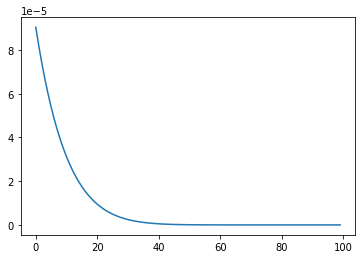

<IPython.core.display.Javascript object>

In [ ]:
from fvcore.common.param_scheduler import PolynomialDecayParamScheduler

param_scheduler = PolynomialDecayParamScheduler(1, 10)
scheduler = LRMultiplier(optim, param_scheduler, max_steps)

lrs = []

for _ in range(max_steps):
    scheduler.step()
    lrs.append(scheduler.get_lr())

plt.plot(lrs)

## WarmupParamScheduler-

In [ ]:
# export
class WarmupParamScheduler(CompositeParamScheduler):
    """
    Add an initial warmup stage to another scheduler.

    Source - https://github.com/facebookresearch/fvcore/blob/master/fvcore/common/param_scheduler.py
    """

    def __init__(
        self,
        scheduler: ParamScheduler,
        warmup_factor: float,
        warmup_length: float,
        warmup_method: str = "linear",
    ):
        """
        Args:
            scheduler: warmup will be added at the beginning of this scheduler
            warmup_factor: the factor w.r.t the initial value of ``scheduler``, e.g. 0.001
            warmup_length: the relative length (in [0, 1]) of warmup steps w.r.t the entire
                training, e.g. 0.01
            warmup_method: one of "linear" or "constant"
        """
        end_value = scheduler(warmup_length)  # the value to reach when warmup ends
        start_value = warmup_factor * scheduler(0.0)
        if warmup_method == "constant":
            warmup = ConstantParamScheduler(start_value)
        elif warmup_method == "linear":
            warmup = LinearParamScheduler(start_value, end_value)
        else:
            raise ValueError("Unknown warmup method: {}".format(warmup_method))
        super().__init__(
            [warmup, scheduler],
            interval_scaling=["rescaled", "fixed"],
            lengths=[warmup_length, 1 - warmup_length],
        )

<IPython.core.display.Javascript object>

## Learning Rate Schedulers-

In [ ]:
# export
@SCHEDULER_REGISTRY.register()
def CosineLR(
    optim: Optimizer,
    max_iters: int,
    start_value: int = 1,
    end_value: int = 0,
) -> torch.optim.lr_scheduler._LRScheduler:
    """
    Cosine decay or cosine warmup schedules based on start and end values.
    These values are relative to the values of your LR's.
    This scheduler is meant to be called after each "training step" .
    """
    param_sched = CosineParamScheduler(start_value, end_value)
    scheduler = LRMultiplier(optim, max_iter=max_iters, multiplier=param_sched)
    return scheduler

<IPython.core.display.Javascript object>

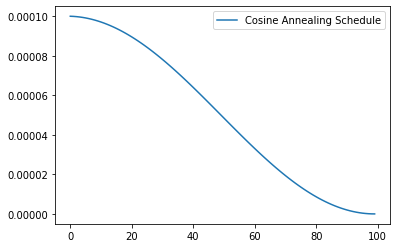

<IPython.core.display.Javascript object>

In [ ]:
scheduler = CosineLR(optim, max_iters=max_steps)

lr = []

for _ in range(epoch):
    for _ in range(batch_nb):
        optim.step()
        optim.zero_grad()
        scheduler.step()
        lr.append(scheduler.get_lr())

plt.plot(lr, label="Cosine Annealing Schedule")
plt.legend()

In [ ]:
# export
@SCHEDULER_REGISTRY.register()
def FlatCosScheduler(
    optimizer: Optimizer,
    pct_start: float,
    max_iters: int,
) -> torch.optim.lr_scheduler._LRScheduler:
    """
    Schedule the LearningRate at flat `lr` for `pct_start` of `max_iters` before cosine annealing.
    This scheduler is meant to be called after a batch has been used for training.

    Inspired From - https://docs.fast.ai/callback.schedule.html#Learner.fit_flat_cos.
    """

    schedulers = [LinearParamScheduler(1, 1), CosineParamScheduler(1, 0)]

    sched = CompositeParamScheduler(
        schedulers,
        lengths=[pct_start, 1 - pct_start],
        interval_scaling=["rescaled", "rescaled"],
    )

    # Wrap Param Scheduler under LRMultiplier class
    sched = LRMultiplier(optimizer, sched, max_iter=max_iters)
    return sched

<IPython.core.display.Javascript object>

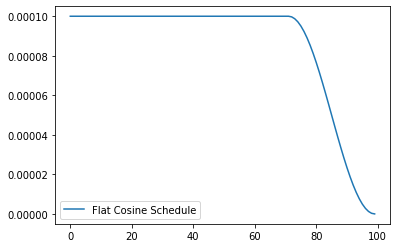

<IPython.core.display.Javascript object>

In [ ]:
lr = []

scheduler = FlatCosScheduler(optim, pct_start=0.72, max_iters=max_steps)

for _ in range(epoch):
    for _ in range(batch_nb):
        optim.step()
        optim.zero_grad()
        scheduler.step()
        lr.append(scheduler.get_lr())

plt.plot(lr, label="Flat Cosine Schedule")
plt.legend()

In [ ]:
# export
@SCHEDULER_REGISTRY.register()
def WarmupCosineLR(
    optimizer: torch.optim.Optimizer,
    max_iters: int,
    pct_start: Optional[float] = None,
    warmup_steps: Optional[int] = None,
    warmup_factor: float = (1.0 / 1000),
) -> torch.optim.lr_scheduler._LRScheduler:
    """
    Linearly increase `lr` for `pct_start` or `warmup_steps` before cosine annealing from
    `pct_start` or `warmup_steps`.
    """

    # warmup iterations
    if pct_start is None and warmup_steps is None:
        raise ValueError("You must define either pct_start OR warmup_steps")

    if warmup_steps is not None and (
        warmup_steps <= 0 or not isinstance(warmup_steps, int)
    ):
        raise ValueError(
            "Expected positive interger warmup_steps, but got {}".format(warmup_steps)
        )
    if pct_start is not None and (pct_start <= 0 and not isinstance(pct_start, float)):
        raise ValueError(
            "Expected positive float pct_start, but got {}".format(pct_start)
        )

    if pct_start is not None:
        warmup_length = pct_start

    elif warmup_steps is not None:
        warmup_length = warmup_steps / max_iters

    sched = CosineParamScheduler(1, 0)

    sched = WarmupParamScheduler(
        sched,
        warmup_factor=warmup_factor,
        warmup_length=warmup_length,
        warmup_method="linear",
    )
    return LRMultiplier(optimizer, multiplier=sched, max_iter=max_iters)

<IPython.core.display.Javascript object>

Arguments to `WarmupCosineLR` -  
* `optimizer` (Optimizer): Wrapped Optimizer.
* `max_iters` (int): The total number of steps to train for.
* `pct_start` (float): The percentage of steps spent increasing the learning rate. Default: None
* `warmup_steps` (int): The no. of steps spent increasing the learning rate. Default: None
* `warmup_factor` (float): The factor w.r.t the initial value of LR in ``scheduler``

> Note: You must either provide `pct_start` or `warmup_steps` & `.step` should be called after a batch has been used for training.

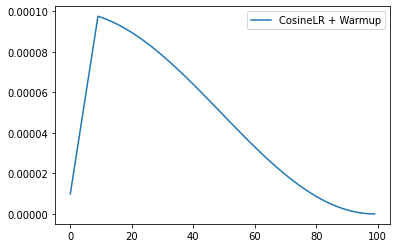

<IPython.core.display.Javascript object>

In [ ]:
lr1 = []

scheduler = WarmupCosineLR(optim, pct_start=0.1, max_iters=max_steps)

for _ in range(epoch):
    for _ in range(batch_nb):
        optim.step()
        scheduler.step()
        lr1.append(scheduler.get_lr())

plt.plot(lr1, label="CosineLR + Warmup")
plt.legend()

In [ ]:
# export
@SCHEDULER_REGISTRY.register()
def WarmupLinearLR(
    optimizer: Optimizer,
    max_iters: int,
    pct_start: Optional[float] = None,
    warmup_steps: Optional[int] = None,
    warmup_factor: float = (1.0 / 1000),
) -> torch.optim.lr_scheduler._LRScheduler:
    """
    Linearly increase `lr` for `pct_start` or `warmup_steps` before
    linear decreasing of `lr`.
    """
    # warmup iterations
    if pct_start is None and warmup_steps is None:
        raise ValueError("You must define either pct_start OR warmup_steps")

    if warmup_steps is not None and (
        warmup_steps <= 0 or not isinstance(warmup_steps, int)
    ):
        raise ValueError(
            "Expected positive interger warmup_steps, but got {}".format(warmup_steps)
        )
    if pct_start is not None and (pct_start <= 0 and not isinstance(pct_start, float)):
        raise ValueError(
            "Expected positive float pct_start, but got {}".format(pct_start)
        )

    if pct_start is not None:
        warmup_length = pct_start

    elif warmup_steps is not None:
        warmup_length = warmup_steps / max_iters

    sched = LinearParamScheduler(1, 0)
    sched = WarmupParamScheduler(
        sched,
        warmup_factor=warmup_factor,
        warmup_length=warmup_length,
        warmup_method="linear",
    )
    return LRMultiplier(optimizer, multiplier=sched, max_iter=max_iters)

<IPython.core.display.Javascript object>

Arguments to `WarmupLinearLR` -  
* `optimizer` (Optimizer): Wrapped Optimizer.
* `max_iters` (int): The total number of steps to train for.
* `pct_start` (float): The percentage of steps spent increasing the learning rate. Default: None
* `warmup_steps` (int): The no. of steps spent increasing the learning rate. Default: None
* `warmup_factor` (float): The factor w.r.t the initial value of LR in ``scheduler``

> Note: You must either provide `pct_start` or `warmup_steps` & `.step` should be called after a batch has been used for training.

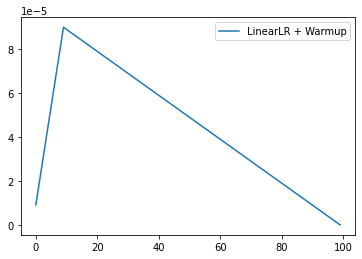

<IPython.core.display.Javascript object>

In [ ]:
lr2 = []

scheduler = WarmupLinearLR(optim, pct_start=0.1, max_iters=max_steps)

for _ in range(epoch):
    for _ in range(batch_nb):
        optim.step()
        scheduler.step()
        lr2.append(scheduler.get_lr())

plt.plot(lr2, label="LinearLR + Warmup")
plt.legend()

In [ ]:
# export
@SCHEDULER_REGISTRY.register()
def WarmupConstantLR(
    optimizer: Optimizer,
    max_iters: int,
    pct_start: Optional[float] = None,
    warmup_steps: Optional[int] = None,
    warmup_factor: float = (1.0 / 1000),
) -> torch.optim.lr_scheduler._LRScheduler:
    """
    Linearly increase `lr` for `pct_start` or `warmup_steps` after
    which keep the `lr` at constant value.
    """
    # warmup iterations
    if pct_start is None and warmup_steps is None:
        raise ValueError("You must define either pct_start OR warmup_steps")

    if warmup_steps is not None and (
        warmup_steps <= 0 or not isinstance(warmup_steps, int)
    ):
        raise ValueError(
            "Expected positive interger warmup_steps, but got {}".format(warmup_steps)
        )
    if pct_start is not None and (pct_start <= 0 and not isinstance(pct_start, float)):
        raise ValueError(
            "Expected positive float pct_start, but got {}".format(pct_start)
        )

    if pct_start is not None:
        warmup_length = pct_start

    elif warmup_steps is not None:
        warmup_length = warmup_steps / max_iters

    sched = LinearParamScheduler(1, 1)
    sched = WarmupParamScheduler(
        sched,
        warmup_factor=warmup_factor,
        warmup_length=warmup_length,
        warmup_method="linear",
    )
    return LRMultiplier(optimizer, multiplier=sched, max_iter=max_iters)

<IPython.core.display.Javascript object>

Arguments to `WarmupConstantLR` -  
* `optimizer` (Optimizer): Wrapped Optimizer.
* `max_iters` (int): The total number of steps to train for.
* `pct_start` (float): The percentage of steps spent increasing the learning rate. Default: None
* `warmup_steps` (int): The no. of steps spent increasing the learning rate. Default: None
* `warmup_factor` (float): The factor w.r.t the initial value of LR in ``scheduler``

> Note: You must either provide `pct_start` or `warmup_steps` & `.step` should be called after a batch has been used for training.

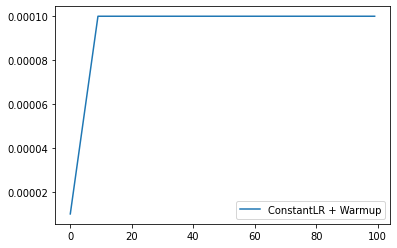

<IPython.core.display.Javascript object>

In [ ]:
lr3 = []

scheduler = WarmupConstantLR(optim, pct_start=0.1, max_iters=max_steps)

for _ in range(epoch):
    for _ in range(batch_nb):
        optim.step()
        scheduler.step()
        lr3.append(scheduler.get_lr())

plt.plot(lr3, label="ConstantLR + Warmup")
plt.legend()

Comparison of all the Warmup LR Schedulers -

Text(0.5, 1.0, 'Warmup LR Schedulers')

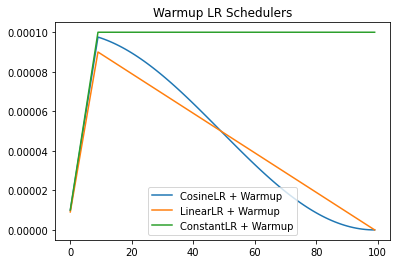

<IPython.core.display.Javascript object>

In [ ]:
plt.plot(lr1, label="CosineLR + Warmup")
plt.plot(lr2, label="LinearLR + Warmup")
plt.plot(lr3, label="ConstantLR + Warmup")
plt.legend()
plt.title("Warmup LR Schedulers")

In [ ]:
# export
@SCHEDULER_REGISTRY.register()
def WarmupStepLR(
    optimizer: Optimizer,
    epochs: int,
    num_decays: int,
    warmup_epochs: int = 0,
    decay_rate: float = 1.0,
    warmup_factor: float = 1e-05,
):
    """
    Decays the learning rate of each parameter group by `decay_rate` at equal number of epochs
    given by `num_decays`. You can optionally add a warmup scheduler using `warmup_epochs`.
    This scheduler is meant to be called after each epoch.
    """
    warmup_length = warmup_epochs / epochs

    sched = StepWithFixedGammaParamScheduler(
        1, num_decays, decay_rate, epochs + 1 - warmup_epochs
    )

    sched = WarmupParamScheduler(
        sched,
        warmup_factor=warmup_factor,
        warmup_length=warmup_length,
        warmup_method="linear",
    )
    return LRMultiplier(optimizer, multiplier=sched, max_iter=epochs + 1)

<IPython.core.display.Javascript object>

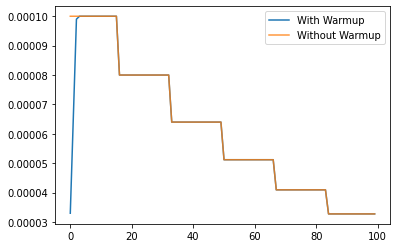

<IPython.core.display.Javascript object>

In [ ]:
lr1, lr2 = [], []
epoch = 100

# fmt: off
scheduler = WarmupStepLR(optim, epochs=epoch, num_decays=5, warmup_epochs=0, decay_rate=0.8)
wrm_scheduler = WarmupStepLR(optim, epochs=epoch, num_decays=5, warmup_epochs=3, decay_rate=0.8)

for _ in range(epoch):
    for _ in range(batch_nb):
        optim.step()
    
    # scheduler is called after each epoch
    scheduler.step()
    wrm_scheduler.step()
    lr1.append(scheduler.get_lr())
    lr2.append(wrm_scheduler.get_lr())

plt.plot(lr2, label="With Warmup")
plt.plot(lr1, alpha=0.8, label="Without Warmup")
plt.legend();

## Export-

In [ ]:
# hide
notebook2script("02a_schedules.ipynb")

Converted 02a_schedules.ipynb.


<IPython.core.display.Javascript object>